# **IPC EDA**

Se realizó el análisis del Índice de Precios y Cotizaciones (IPC) de México para el periodo comprendido entre el 1 de enero de 2020 y el 31 de agosto de 2025.

El objetivo de este apartado es evaluar el comportamiento histórico del índice, identificar patrones relevantes y validar la calidad de los datos utilizados.

A lo largo de esta sección se presenta un análisis estadístico y temporal de la serie, que incluye el estudio de su distribución, tendencia, estacionalidad y volatilidad, así como la comparación entre los resultados obtenidos antes y después del proceso de imputación de datos.

In [88]:
# Importar librerias
import pandas as pd
import numpy as np
from typing import Tuple, Dict, Any
import matplotlib.pyplot as plt
import sys, os
ROOT = os.path.abspath(os.path.join(os.getcwd(), "..", ".."))
sys.path.append(ROOT)
from utils.date import calendario_df, datetime_index
from scipy import stats
from scipy.stats import jarque_bera
from statsmodels.tsa.seasonal import STL
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.stats.diagnostic import acorr_ljungbox


In [56]:
df_ipc = pd.read_csv("../raw/ipc_history_2025-01-01_to_2025-08-31.csv")

In [20]:
df_ipc

,Date,Open,High,Low,Close,Volume
0,2019-12-30,44318.898438,44347.738281,43451.488281,43657.480469,81802900
1,2019-12-31,43668.710938,43705.359375,43439.679688,43541.019531,46721800
2,2020-01-02,43739.519531,44521.519531,43716.488281,44437.230469,95180400
3,2020-01-03,44355.210938,44742.980469,44177.910156,44624.851562,103484500
4,2020-01-06,44489.968750,44571.738281,44287.128906,44495.300781,86928400
...,...,...,...,...,...,...
1423,2025-08-25,59242.390625,59250.210938,58400.128906,58492.128906,130126700
1424,2025-08-26,58504.218750,58623.460938,58058.011719,58132.398438,370248900
1425,2025-08-27,58138.320312,58699.371094,57623.871094,58647.519531,178606200
1426,2025-08-28,58663.988281,59421.609375,58531.281250,59151.679688,159754300


Generamos el calendario con las fechas faltantes para la serie, dando un resumen de las filas que se insertaron.

Teniendo df_ipc_f el calnedario completo, tanto dias operables como no opearables

In [57]:
df_ipc_f, info_ipc = calendario_df(df_ipc, date_col="Date")

In [58]:
info_ipc

{'filas_originales': 1428,
 'filas_esperadas': 2072,
 'filas_insertadas': 644,
 'primer_falta': datetime.date(2020, 1, 1),
 'ultima_falta': datetime.date(2025, 8, 31)}

In [59]:
df_ipc_f

,Date,Open,High,Low,Close,Volume
0,2019-12-30,44318.898438,44347.738281,43451.488281,43657.480469,81802900.0
1,2019-12-31,43668.710938,43705.359375,43439.679688,43541.019531,46721800.0
2,2020-01-01,NaN,NaN,NaN,NaN,NaN
3,2020-01-02,43739.519531,44521.519531,43716.488281,44437.230469,95180400.0
4,2020-01-03,44355.210938,44742.980469,44177.910156,44624.851562,103484500.0
...,...,...,...,...,...,...
2067,2025-08-27,58138.320312,58699.371094,57623.871094,58647.519531,178606200.0
2068,2025-08-28,58663.988281,59421.609375,58531.281250,59151.679688,159754300.0
2069,2025-08-29,59218.578125,59256.859375,58670.570312,58708.859375,174166900.0
2070,2025-08-30,NaN,NaN,NaN,NaN,NaN


In [60]:
# Obtener columnas a trabjar
df_ipc = df_ipc.reset_index()[['Date', 'Close']].copy()
df_ipc['Date'] = pd.to_datetime(df_ipc['Date'])
df_ipc = df_ipc.rename(columns={'# Close': 'Close'})

In [61]:
# Para calendario completo
df_ipc_f = datetime_index(df_ipc_f, date_col="Date", dayfirst=False)
# Para calendario de negociacion
df_ipc = datetime_index(df_ipc, date_col="Date", dayfirst=False)

Para saber el tratamiento de datos que se le debe de aplicar a esta variable, analizaremos el patron de dias faltantes, la tendencia de la serie como la volatilidad.

### **Analisis de Datos Faltantes**

En est

In [62]:
def missing_weekday_weekend(df: pd.DataFrame) -> pd.DataFrame:
    if not isinstance(df.index, pd.DatetimeIndex):
        raise ValueError("El índice debe ser DatetimeIndex.")
    isna = df.isna()
    is_weekend = pd.Series(df.index.weekday >= 5, index=df.index)

    weekend_missing = (isna & is_weekend.values[:, None]).sum(axis=0)
    weekday_missing = (isna & (~is_weekend).values[:, None]).sum(axis=0)

    out = pd.DataFrame({
        "weekday_missing": weekday_missing.astype(int),
        "weekend_missing": weekend_missing.astype(int),
    })
    out["total_missing"] = out["weekday_missing"] + out["weekend_missing"]
    return out.sort_values("total_missing", ascending=False)

In [63]:
def plot_weekday_weekend_missing(df: pd.DataFrame):
    tbl = missing_weekday_weekend(df)
    x = np.arange(len(tbl.index))
    w = 0.4

    fig, ax = plt.subplots(figsize=(8, 4))
    ax.bar(x - w/2, tbl["weekday_missing"].values, width=w, label="Entre semana (L–V)")
    ax.bar(x + w/2, tbl["weekend_missing"].values, width=w, label="Fin de semana (S–D)")

    ax.set_xticks(x)
    ax.set_xticklabels(tbl.index, rotation=45, ha="right")
    ax.set_ylabel("Conteo de nulos")
    ax.set_title("Nulos por columna: Entre semana vs Fin de semana")
    ax.legend()
    plt.tight_layout()
    plt.show()
    return tbl

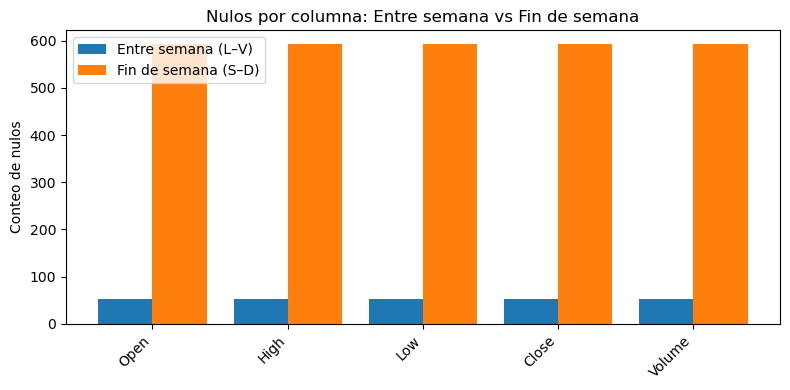

,weekday_missing,weekend_missing,total_missing
Open,52,592,644
High,52,592,644
Low,52,592,644
Close,52,592,644
Volume,52,592,644


In [64]:
plot_weekday_weekend_missing(df_ipc_f)

Para el análisis de días faltantes de la serie del IPC, el conteo de faltantes se concentra en fines de 
semana: se registran 592 nulos frente a 52 en días hábiles, para un total de 644.

In [29]:
def missing_by_weekday_counts(df: pd.DataFrame) -> pd.DataFrame:
    if not isinstance(df.index, pd.DatetimeIndex):
        raise ValueError("El índice debe ser DatetimeIndex.")

    # Filtrar solo L–V
    df_biz = df[df.index.weekday < 5]
    isna = df_biz.isna()
    dow = df_biz.index.weekday  # 0..4

    counts = {}
    for col in df_biz.columns:
        c = pd.Series(dow[isna[col]].value_counts()).reindex(range(5), fill_value=0).astype(int)
        counts[col] = c

    counts_df = pd.DataFrame(counts).T
    counts_df.columns = ["Mon","Tue","Wed","Thu","Fri"]
    return counts_df

In [30]:
def plot_missing_by_weekday_counts(df: pd.DataFrame):
    
    counts_df = missing_by_weekday_counts(df)
    dow_labels = ["Mon","Tue","Wed","Thu","Fri"]

    for col in counts_df.index:
        fig, ax = plt.subplots(figsize=(6, 3.3))
        ax.bar(range(5), counts_df.loc[col].values)
        ax.set_xticks(range(5))
        ax.set_xticklabels(dow_labels)
        ax.set_title(f"Nulos por día (L–V): {col}")
        ax.set_xlabel("Día de la semana")
        ax.set_ylabel("Conteo de nulos")
        plt.tight_layout()
        plt.show()
    return counts_df

In [31]:
counts_df = missing_by_weekday_counts(df_ipc_f)
counts_df

,Mon,Tue,Wed,Thu,Fri
Open,23,3,6,10,10
High,23,3,6,10,10
Low,23,3,6,10,10
Close,23,3,6,10,10
Volume,23,3,6,10,10


En días hábiles, la mayor incidencia ocurre los lunes con 23 nulos, martes 3, miércoles 6, jueves 10 y viernes 10.

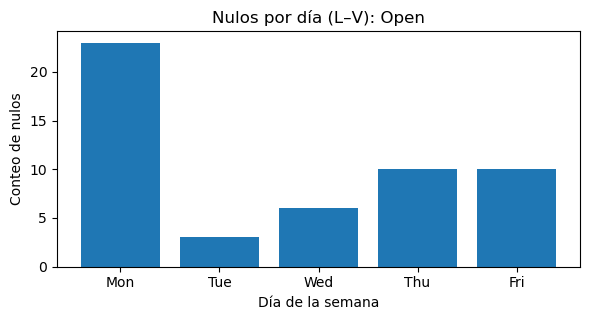

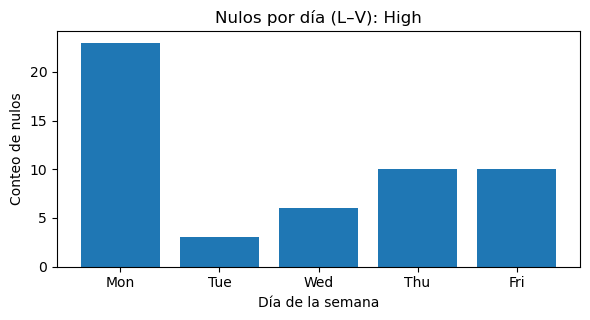

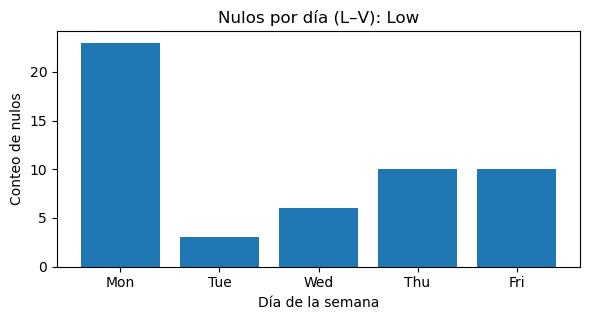

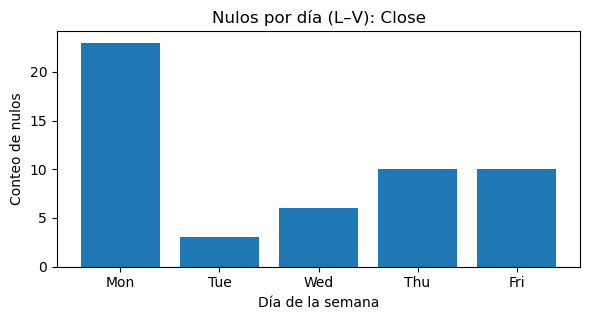

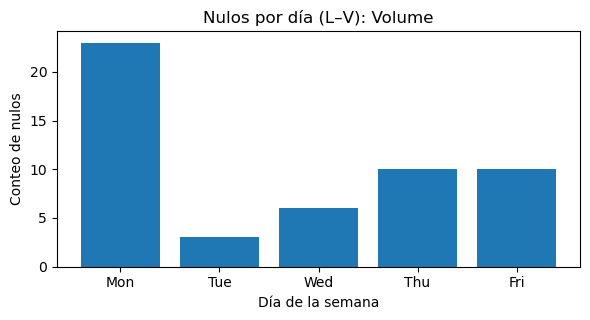

In [32]:
counts_df = plot_missing_by_weekday_counts(df_ipc_f)

También se realizó un análisis que relaciona los días hábiles faltantes con los días festivos del calendario, el patrón no es aleatorio, ya que los nulos corresponden a 
cierres sistemáticos de mercado y a festividades oficiales. 

In [33]:
null_days = df_ipc_f[df_ipc_f.isna().any(axis=1)]

# Filtrar solo días entre semana 
weekday_nulls = null_days[null_days.index.weekday < 5]
weekday_nulls.index


DatetimeIndex(['2020-01-01', '2020-02-03', '2020-03-16', '2020-04-09',
               '2020-04-10', '2020-05-01', '2020-09-16', '2020-11-02',
               '2020-11-16', '2020-12-25', '2021-01-01', '2021-02-01',
               '2021-03-15', '2021-04-01', '2021-04-02', '2021-09-16',
               '2021-11-02', '2021-11-15', '2022-02-07', '2022-03-21',
               '2022-04-14', '2022-04-15', '2022-09-16', '2022-11-02',
               '2022-11-21', '2022-12-12', '2023-02-06', '2023-03-20',
               '2023-04-06', '2023-04-07', '2023-05-01', '2023-11-02',
               '2023-11-20', '2023-12-12', '2023-12-25', '2024-01-01',
               '2024-02-05', '2024-03-18', '2024-03-28', '2024-03-29',
               '2024-05-01', '2024-09-16', '2024-10-01', '2024-11-18',
               '2024-12-12', '2024-12-25', '2025-01-01', '2025-02-03',
               '2025-03-17', '2025-04-17', '2025-04-18', '2025-05-01'],
              dtype='datetime64[ns]', name='Date', freq=None)

In [34]:
import pandas as pd
import numpy as np

def gaps_nan_corridas(df_or_series, value_col=None, solo_habiles=False):
    """
    Detecta corridas consecutivas de NaN en una serie diaria y las agrupa en 1,2,3,4,>=5.
    Retorna (detalle, resumen).
    """
    # 1) Obtener la serie s
    if isinstance(df_or_series, pd.DataFrame):
        if value_col is None:
            num_cols = df_or_series.select_dtypes(include=[np.number]).columns
            if len(num_cols) == 0:
                raise ValueError("Especifica 'value_col'; no hay columnas numéricas.")
            value_col = num_cols[0]
        s = df_or_series[value_col]
    else:
        s = df_or_series

    # Asegurar índice datetime diario y ordenado
    s = s.copy()
    s.index = pd.to_datetime(s.index).tz_localize(None).normalize()
    s = s.sort_index()

    # 2) Opcional: quedarse solo con días hábiles (L-V)
    if solo_habiles:
        s = s[s.index.weekday < 5]

    if s.empty:
        return (pd.DataFrame(columns=["inicio","fin","longitud","bucket"]),
                pd.Series({1:0,2:0,3:0,4:0,">=5":0}))

    # 3) Corridas de NaN: agrupar True consecutivos
    mask = s.isna()
    if not mask.any():
        return (pd.DataFrame(columns=["inicio","fin","longitud","bucket"]),
                pd.Series({1:0,2:0,3:0,4:0,">=5":0}))

    grp = mask.ne(mask.shift()).cumsum()          # id de bloque cada vez que cambia True/False
    sizes = mask.groupby(grp).size()              # tamaño de cada bloque
    is_nan = mask.groupby(grp).first()            # si el bloque es NaN o no

    runs = pd.DataFrame({"longitud": sizes, "es_nan": is_nan})
    runs = runs[runs["es_nan"]]                   # quedarnos con bloques de NaN

    # Obtener inicio y fin (fechas) de cada corrida
    idx_by_grp = s.index.to_series().groupby(grp)
    inicios = idx_by_grp.first()[runs.index]
    fines   = idx_by_grp.last()[runs.index]

    detalle = pd.DataFrame({
        "inicio": inicios.values,
        "fin": fines.values,
        "longitud": runs["longitud"].values
    }).sort_values("inicio").reset_index(drop=True)

    # 4) Buckets
    detalle["bucket"] = detalle["longitud"].apply(lambda k: k if k in {1,2,3,4} else ">=5")
    resumen = (detalle["bucket"].value_counts()
               .reindex([1,2,3,4,">=5"], fill_value=0)
               .astype(int))

    return detalle, resumen


In [ ]:
# Solo días hábiles
detalle_biz, resumen_biz = gaps_nan_corridas(df_ipc_f, value_col="Close", solo_habiles=True)

También se realizo un analisis de corridas del calendario, reportando la longitud de corridas para días habiles. Esto con el proposito de conocer el metodo de imputacion a ocupar, por la longitud de dias sin informacion

In [24]:
# Dias Habiles
resumen_biz

bucket
1      40
2       6
3       0
4       0
>=5     0
Name: count, dtype: int32

El siguiente df muestralos dias entre semana , que no presentan informacion, y si son gaps de 1 dia o de 2 dias

In [65]:

detalle_biz

,inicio,fin,longitud,bucket
0,2020-01-01,2020-01-01,1,1
1,2020-02-03,2020-02-03,1,1
2,2020-03-16,2020-03-16,1,1
3,2020-04-09,2020-04-10,2,2
4,2020-05-01,2020-05-01,1,1
5,2020-09-16,2020-09-16,1,1
6,2020-11-02,2020-11-02,1,1
7,2020-11-16,2020-11-16,1,1
8,2020-12-25,2020-12-25,1,1
9,2021-01-01,2021-01-01,1,1


Con este primer análisis, se puede decir que los fines de semana no son operativos, que el patrón es 
estructural y que la mayoría de los nulos en hábiles proviene de festividades. Para la imputación, 
conviene centrar el tratamiento en los huecos de días hábiles y completar fines de semana con el cierre 
del viernes mediante forward-fill. 

### **Analizar distribucion de datos**

Como siguiente paso se realiza el análisis de distribución, aplicar el estudio sobre la serie en 
calendario operativo, solo días hábiles, con el fin de caracterizar su comportamiento antes de imputar.

In [68]:
if '# Close' in df_ipc.columns and 'Close' not in df_ipc.columns:
    df_ipc = df_ipc.rename(columns={'# Close': 'Close'})

if 'Date' in df_ipc.columns:
    df_ipc['Date'] = pd.to_datetime(df_ipc['Date'], errors='coerce')
    df_ipc = df_ipc.sort_values('Date')
    # quita duplicados por fecha (si hubiera)
    df_ipc = df_ipc[~df_ipc['Date'].duplicated(keep='first')]
    s = df_ipc.set_index('Date')['Close']
else:
    # La fecha ya viene como índice
    df_ipc = df_ipc.copy()
    df_ipc.index = pd.to_datetime(df_ipc.index, errors='coerce')
    df_ipc = df_ipc.sort_index()
    # quita duplicados en el índice fecha
    df_ipc = df_ipc[~df_ipc.index.duplicated(keep='first')]
    s = df_ipc['Close']

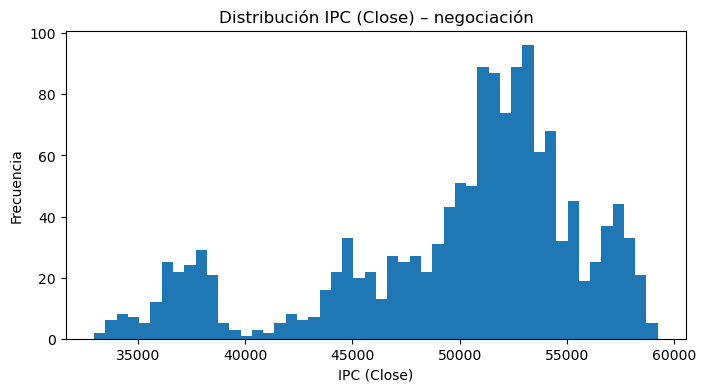

In [69]:
plt.figure(figsize=(8,4))
plt.hist(s, bins=50)
plt.title('Distribución IPC (Close) – negociación')
plt.xlabel('IPC (Close)'); plt.ylabel('Frecuencia')
plt.show()

Se implementó el histograma del IPC en niveles donde se muestra multimodalidad y amplia 
dispersión, consistentes en periodos con comportamientos distintos a lo largo del tiempo. La forma 
sugiere sesgo a la derecha en niveles, mostrando que la serie es no estacionaria, como se muestra en la 
figura 

Para complementar el estudio de distribución, se elaboró un diagrama de caja sobre los valores de 
cierre del IPC, junto con el cálculo de estadísticas descriptivas básicas. Se observa que 
la serie presenta una asimetría negativa, con varios valores atípicos concentrados en la parte inferior 
del gráfico.

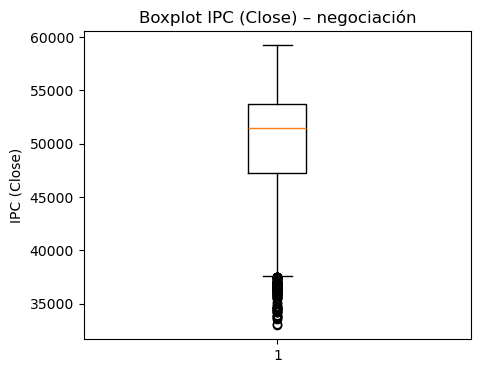

In [70]:
plt.figure(figsize=(5,4))
plt.boxplot(s.values, vert=True, showfliers=True)
plt.title('Boxplot IPC (Close) – negociación'); plt.ylabel('IPC (Close)')
plt.show()

In [29]:
desc = s.describe()
skew_raw = s.skew()
kurt_raw = s.kurt()
print(desc)
print(f"Asimetría (skew): {skew_raw:.4f}")
print(f"Curtosis (kurt): {kurt_raw:.4f}")


count     1428.000000
mean     49865.915630
std       5994.359808
min      32964.218750
25%      47245.148438
50%      51460.791016
75%      53739.102539
max      59225.480469
Name: Close, dtype: float64
Asimetría (skew): -1.0126
Curtosis (kurt): 0.2858


El resumen estadístico indica un promedio de 49 865 puntos y una desviación estándar de 
5 994, reflejando una dispersión moderada respecto a la media. La asimetría confirma el sesgo hacia 
valores bajos. 

Tambien se estimaron las densidades mediante KDE y se construyeron diagramas Q-Q comparando la 
distribución empírica con la normal teórica. 

In [72]:
# Serie base
s = df_ipc['Close'].copy()
r = s.pct_change().dropna()
log_s = np.log(s[s>0])

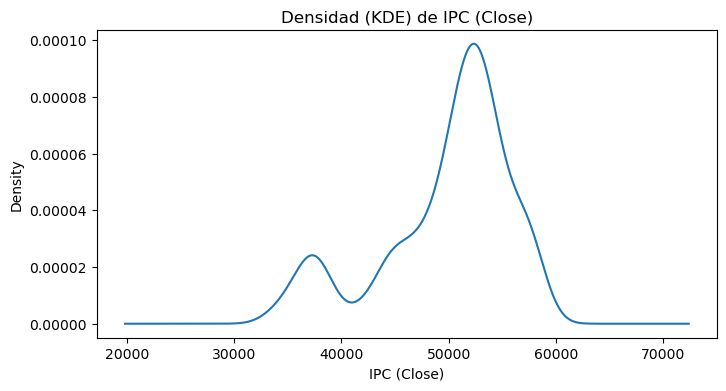

In [73]:
# 1) KDE (niveles)
plt.figure(figsize=(8,4))
s.plot(kind='kde')
plt.title('Densidad (KDE) de IPC (Close)'); plt.xlabel('IPC (Close)')
plt.show()


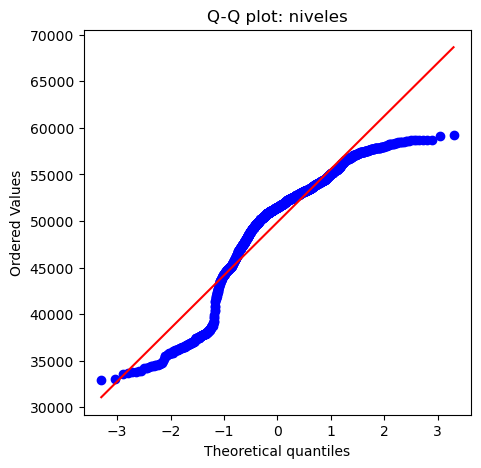

In [34]:
# 2) Q-Q plot (niveles)
plt.figure(figsize=(5,5))
stats.probplot(s, dist="norm", plot=plt)
plt.title('Q-Q plot: niveles')
plt.show()

In [74]:
print("JB niveles:", jarque_bera(s.dropna()))

JB niveles: SignificanceResult(statistic=248.19694377579663, pvalue=1.272677735280967e-54)


 La densidad del IPC en niveles muestra multimodalidad y amplia dispersión, reflejando distintos regímenes de comportamiento a lo largo del tiempo. 

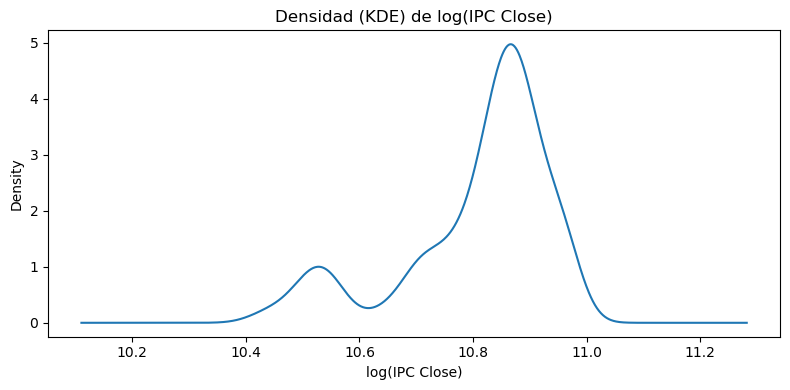

In [ ]:
# 2) KDE (log-niveles)
log_s = np.log(s[s > 0]).dropna()

plt.figure(figsize=(8,4))
log_s.plot(kind='kde')  
plt.title('Densidad (KDE) de log(IPC Close)')
plt.xlabel('log(IPC Close)')
plt.tight_layout()
plt.show()


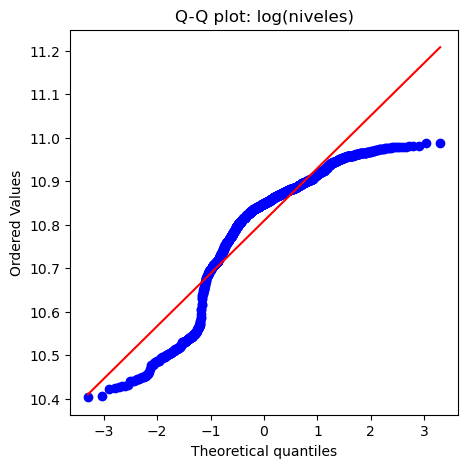

In [35]:
# Q-Q plot (log niveles)
plt.figure(figsize=(5,5))
stats.probplot(log_s, dist="norm", plot=plt)
plt.title('Q-Q plot: log(niveles)')
plt.show()


In [75]:
print("JB log:    ", jarque_bera(log_s.dropna()))

JB log:     SignificanceResult(statistic=409.47239406121554, pvalue=1.2139460428142599e-89)


Al aplicar la transformación logarítmica , la forma se suaviza. El KDE de 
log(IPC) muestra una distribución claramente no normal, con un pico principal y un abultamiento secundario; el Q–Q plot exhibe una “S” marcada (colas pesadas y algo de asimetría). El test de Jarque–Bera es muy significativo (JB≈409; p≈1e-89), por lo que se rechaza normalidad

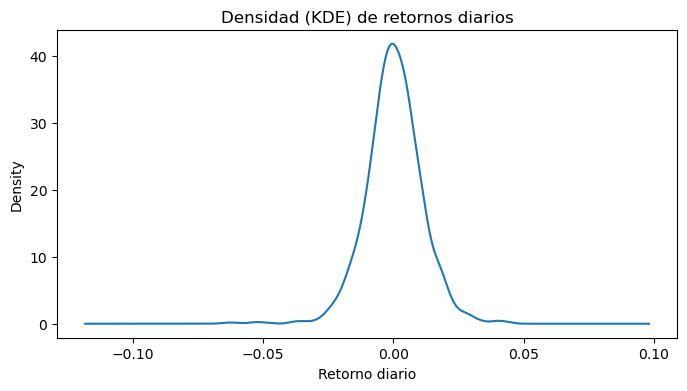

In [33]:
# KDE de retornos
plt.figure(figsize=(8,4))
r.plot(kind='kde')
plt.title('Densidad (KDE) de retornos diarios'); plt.xlabel('Retorno diario')
plt.show()

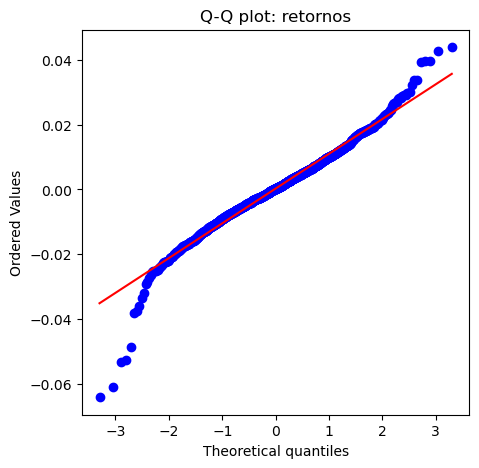

In [36]:
# Q-Q plot (retornos)
plt.figure(figsize=(5,5))
stats.probplot(r, dist="norm", plot=plt)
plt.title('Q-Q plot: retornos')
plt.show()

In [76]:
# 3) Jarque–Bera
print("JB retornos:", jarque_bera(r.dropna()))

JB retornos: SignificanceResult(statistic=571.9030002398086, pvalue=6.498923217622871e-125)


 Por su parte, los retornos logarítmicos presentan una distribución centrada en cero, y con colas algo pesadas; el Q–Q plot muestra desvíos sustanciales en ambas colas (leptocurtosis) y ligera asimetría. El Jarque–Bera también es altamente significativo , confirmando no normalidad.

Se imputará en log(niveles) porque esta transformación refleja mejor cómo cambian los precios en la realidad, ya que los precios crecen de forma multiplicativa y no de manera lineal.

### **Tendencia**

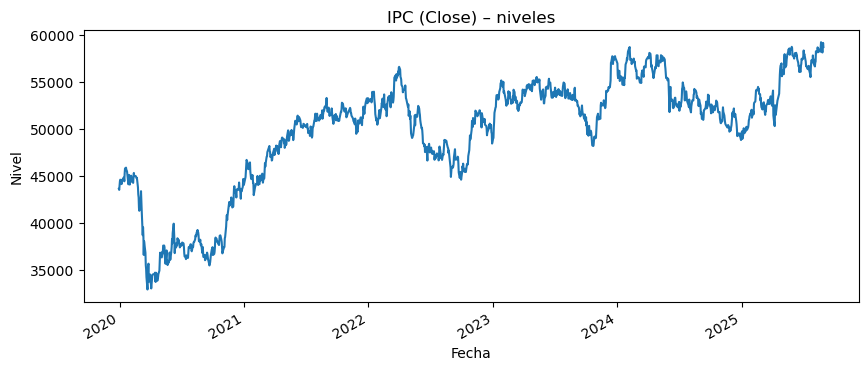

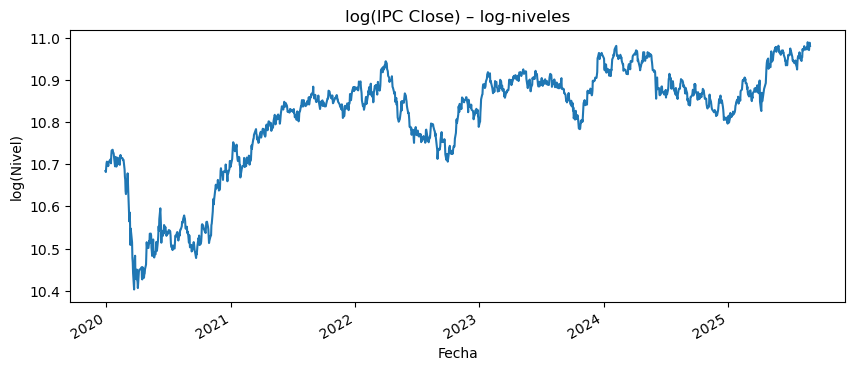

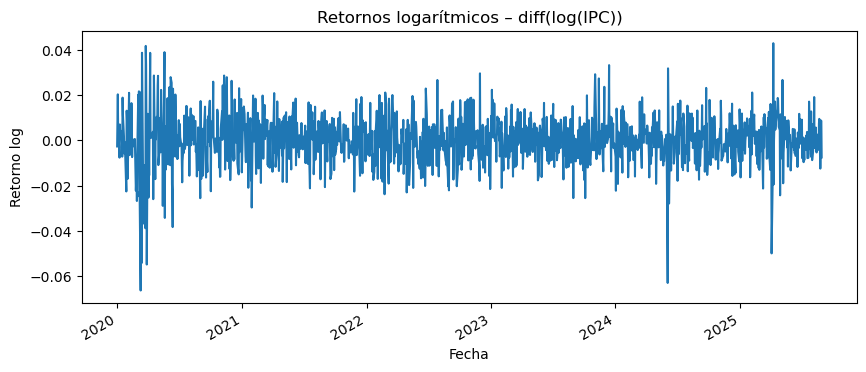

In [80]:
# s: Serie de precios

plt.figure(figsize=(10,4))
s.plot()
plt.title('IPC (Close) – niveles')
plt.ylabel('Nivel'); plt.xlabel('Fecha')
plt.show()

# ---- Transformaciones seguras ----
if (s > 0).all():
    log_s = np.log(s)

    plt.figure(figsize=(10,4))
    log_s.plot()
    plt.title('log(IPC Close) – log-niveles')
    plt.ylabel('log(Nivel)'); plt.xlabel('Fecha')
    plt.show()

    # Retornos log (equivalentes a diff de log)
    lr = log_s.diff().dropna()

    plt.figure(figsize=(10,4))
    lr.plot()
    plt.title('Retornos logarítmicos – diff(log(IPC))')
    plt.ylabel('Retorno log'); plt.xlabel('Fecha')
    plt.show()
else:
    log_s = None
    print("Hay valores no positivos; se omite log(niveles) y retornos log.")


La transformación logarítmica del IPC suaviza la tendencia y estabiliza la varianza; por ello se imputará en log(niveles) para respetar la dinámica multiplicativa y mantener positividad. En cambio, el análisis y la modelación se realizarán sobre los retornos logarítmicos, ya que éstos se comportan aproximadamente como una serie estacionaria en media y varianza más estables

También se aplicó MA y STD móviles sobre log(IPC) que miden la tendencia y la volatilidad de la serie en el tiempo, consideramos que son clave para identificar cambios de comportamiento en la serie y así elegir un método de imputación

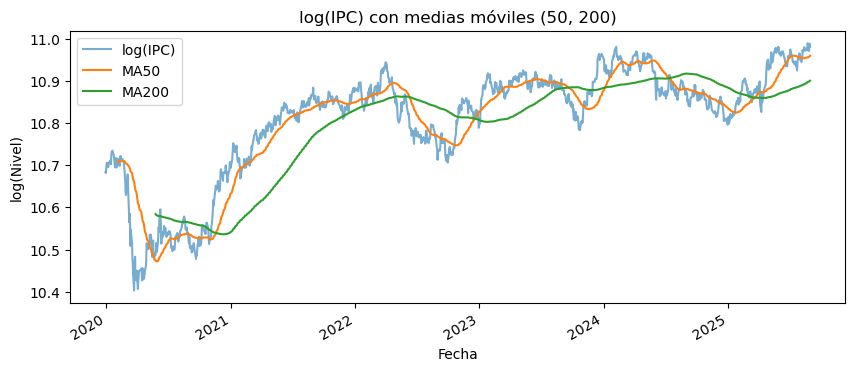

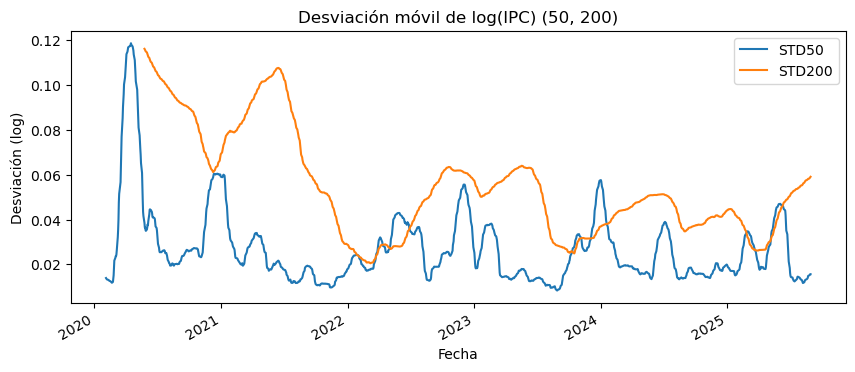

In [ ]:
# s: serie de niveles con índice de fechas
assert (s > 0).all(), "La serie debe ser positiva para usar log."
log_s = np.log(s)

rolls = {}
for w in [50, 200]:
    # promedio y desviación móviles (causales por defecto)
    ma = log_s.rolling(w, min_periods=w//2).mean()
    std = log_s.rolling(w, min_periods=w//2).std()

    # opcional: desplaza 1 día para evitar look-ahead estrictamente
    # ma = ma.shift(1); std = std.shift(1)

    rolls[f"ma{w}"]  = ma
    rolls[f"std{w}"] = std

# --- Gráficas ---
plt.figure(figsize=(10,4))
log_s.plot(alpha=0.6)
rolls["ma50"].plot()
rolls["ma200"].plot()
plt.title('log(IPC) con medias móviles (50, 200)')
plt.legend(['log(IPC)','MA50','MA200'])
plt.ylabel('log(Nivel)'); plt.xlabel('Fecha')
plt.show()

plt.figure(figsize=(10,4))
rolls["std50"].plot()
rolls["std200"].plot()
plt.title('Desviación móvil de log(IPC) (50, 200)')
plt.legend(['STD50','STD200'])
plt.ylabel('Desviación (log)'); plt.xlabel('Fecha')
plt.show()

La primera gráfica muestra etapas de avance y de corrección: cuando las curvas van juntas hay una tendencia estable, y cuando se separan o se cruzan aparecen cambios de dirección. La segunda evidencia volatilidad,fue muy alta en 2020, coherente con el inicio de la pandemia de COVID-19, y más moderada después, con algunos repuntes. En otras palabras, vemos periodos tranquilos y periodos turbulentos. Con base en esto, se prpone una imputación en log(niveles), usando métodos suaves (lineal/spline en log) en tramos estables y métodos conservadores (LOCF o lineal corto en log) cuando la volatilidad sea alta

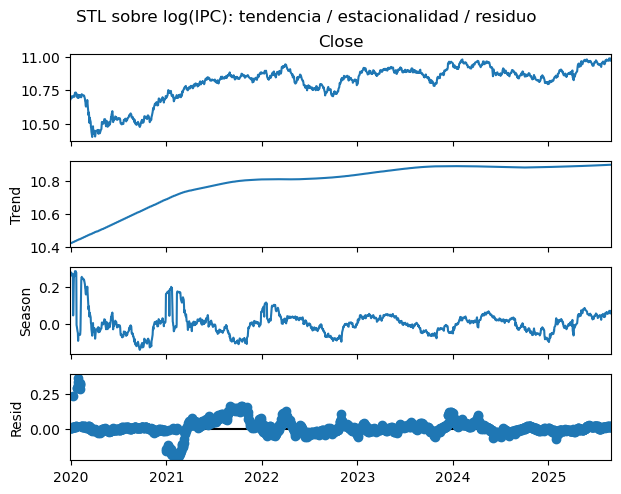

Fuerza de tendencia (STL, sobre log(IPC)): 0.825


In [82]:
# Asegurarte de tener log_s calculado y sin nulos al inicio
series_for_stl = log_s.dropna()

# Descomposición STL (252 días hábiles ≈ 1 año)
stl = STL(series_for_stl, period=252, robust=True)
res = stl.fit()

# --- Gráfica ---
res.plot()
plt.suptitle('STL sobre log(IPC): tendencia / estacionalidad / residuo', y=1.02)
plt.show()

# --- Cálculo de fuerza de tendencia ---
var_total = np.var(series_for_stl)
var_resid = np.var(res.resid.dropna())
trend_strength = 1 - (var_resid / var_total)

print(f"Fuerza de tendencia (STL, sobre log(IPC)): {trend_strength:.3f}")

Este análisis con STL (Seasonal-Trend decomposition using Loess) se realizó para separar el comportamiento del IPC en log(niveles) en sus componentes de tendencia, estacionalidad y residuo.
En la gráfica se observa una tendencia clara y creciente , una estacionalidad débil  y un residuo moderado con picos en 2020.
El indicador de fuerza de tendencia = 0.825 confirma que la serie está fuertemente guiada por una tendencia, por lo que la imputación en log(niveles) con métodos suaves (lineal en log o spline en log) puede ser adecuada.

### **Autocorrelacion**

In [90]:
from statsmodels.tsa.tsatools import detrend

In [91]:
# Serie base (negociación)
s = df_ipc['Close'].sort_index()
r = s.pct_change().dropna()
r_log = np.log(s).diff().dropna()

<Figure size 800x300 with 0 Axes>

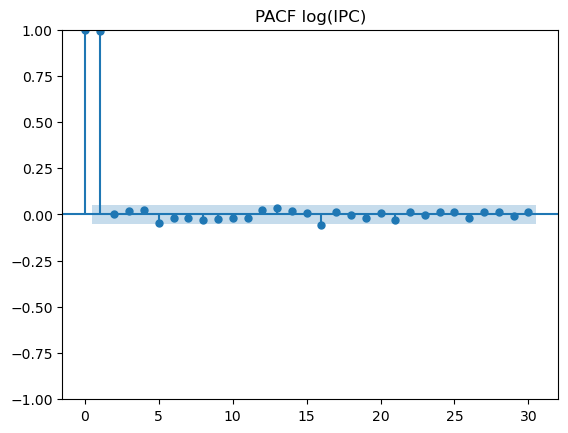

In [ ]:
# --- ACF/PACF de log-niveles
lags = 30
log_s_detr = detrend(log_s.values, order=1)      
log_s_detr = pd.Series(log_s_detr, index=log_s.index)

plt.figure(figsize=(8,3)); plot_pacf(log_s_detr, lags=lags, method='ywm'); plt.title('PACF log(IPC)'); plt.show()

<Figure size 800x300 with 0 Axes>

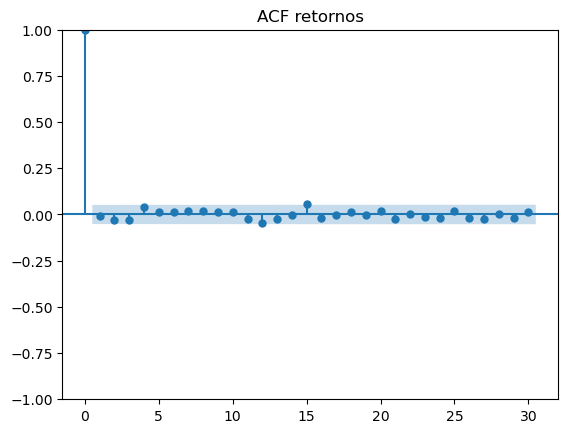

<Figure size 800x300 with 0 Axes>

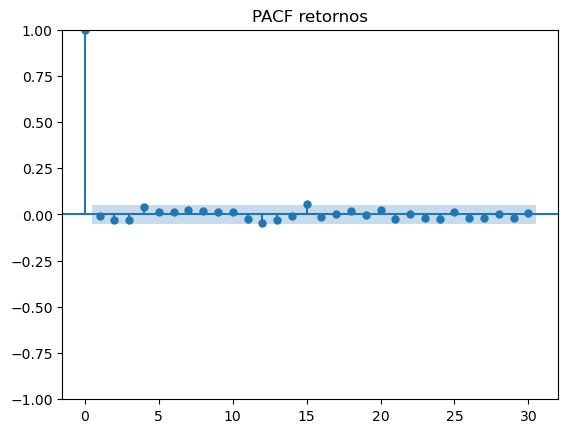

In [95]:
# ACF/PACF de retornos
lags = 30 
plt.figure(figsize=(8,3)); plot_acf(r, lags=lags); plt.title('ACF retornos'); plt.show()
plt.figure(figsize=(8,3)); plot_pacf(r, lags=lags, method='ywm'); plt.title('PACF retornos'); plt.show()

<Figure size 800x300 with 0 Axes>

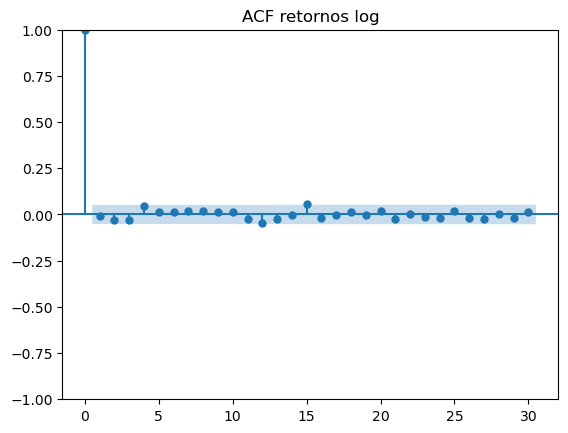

<Figure size 800x300 with 0 Axes>

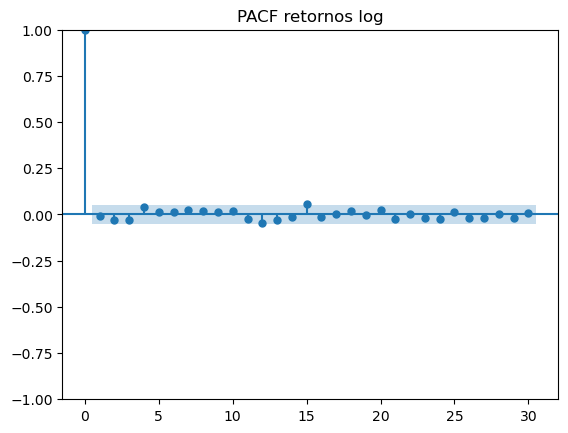

In [94]:
# (opcional) en retornos log
plt.figure(figsize=(8,3)); plot_acf(r_log, lags=lags); plt.title('ACF retornos log'); plt.show()
plt.figure(figsize=(8,3)); plot_pacf(r_log, lags=lags, method='ywm'); plt.title('PACF retornos log'); plt.show()

Las gráficas de ACF y PACF permiten analizar la dependencia temporal de la serie. En el caso del log(IPC), la PACF muestra correlaciones significativas en los primeros rezagos, lo que indica una fuerte tendencia y confirma que la serie no es estacionaria. En cambio, las gráficas de ACF y PACF de los retornos y retornos logarítmicos muestran que, después del primer rezago, las correlaciones caen rápidamente dentro del intervalo de confianza, lo que sugiere que los retornos son esencialmente ruido blanco y, por tanto, estacionarios. Esto respalda la elección de trabajar con retornos logarítmicos para el análisis y modelado, ya que eliminan la tendencia observada en los log-niveles.

### **Metodo de imputacion**

Finalmente , se ocupó log-linear para rellenar huecos de 1–2 días hábiles porque respeta la dinámica multiplicativa del precio (trabaja en log-niveles), garantiza positividad y, con huecos tan cortos, es prácticamente óptimo. Para fines de semana y feriados aplicamos LOCF (forward fill) porque no hay formación de precios en esos días: el valor relevante es el último cierre disponible.

In [ ]:
import numpy as np
import pandas as pd


def _ensure_datetime_index(df, col_date='Date'):
    df = df.copy()
    # normaliza nombre de columna de precio
    if '# Close' in df.columns and 'Close' not in df.columns:
        df = df.rename(columns={'# Close':'Close'})
    if col_date in df.columns:
        df[col_date] = pd.to_datetime(df[col_date], errors='coerce')
        df = df.sort_values(col_date).drop_duplicates(col_date).set_index(col_date)
    else:
        df.index = pd.to_datetime(df.index, errors='coerce')
        df = df.sort_index()
    return df


df_ipc   = _ensure_datetime_index(df_ipc)     
df_ipc_f = _ensure_datetime_index(df_ipc_f)   


out = df_ipc_f[['Close']].copy()
out['Close_imputed'] = out['Close']          
out['method'] = np.where(out['Close'].notna(), 'original', None)

trade_dates = df_ipc.index.sort_values().to_list()


for i in range(1, len(trade_dates)):
    t0, t1 = trade_dates[i-1], trade_dates[i]
    miss = pd.bdate_range(t0 + pd.Timedelta(days=1), t1 - pd.Timedelta(days=1))
    if len(miss) == 0:
        continue
    p0 = float(df_ipc.loc[t0, 'Close'])
    p1 = float(df_ipc.loc[t1, 'Close'])
    if p0 <= 0 or p1 <= 0:
        continue 
    log0, log1 = np.log(p0), np.log(p1)
    n = len(miss)
    vals = []
    for k, d in enumerate(miss, start=1):
        w = k / (n + 1.0)                         
        logd = (1 - w) * log0 + w * log1         
        vals.append(np.exp(logd))
    out.loc[miss, 'Close_imputed'] = vals
    out.loc[miss, 'method'] = 'log-linear'


still_nan = out['Close_imputed'].isna()

out.loc[still_nan, 'Close_imputed'] = out['Close_imputed'].ffill()
filled_now = still_nan & out['Close_imputed'].notna()
out.loc[filled_now, 'method'] = 'ffill (no-operado)'


lead_nan = out['Close_imputed'].isna()
if lead_nan.any():
    out.loc[lead_nan, 'Close_imputed'] = out['Close_imputed'].bfill()
    out.loc[lead_nan & out['Close_imputed'].notna(), 'method'] = out.loc[lead_nan & out['Close_imputed'].notna(), 'method'].fillna('bfill-inicio')


resumen = out['method'].value_counts(dropna=False)
print("Imputación completada.\nConteo por método:\n", resumen)



Imputación completada.
Conteo por método:
 method
original              1428
ffill (no-operado)     592
log-linear              52
Name: count, dtype: int64


In [55]:
# Asegura que el índice sea la fecha y que salga con el nombre 'Date'
tmp = out.copy()
tmp.index.name = 'Date'

# Quédate sólo con la columna imputada y renómbrala a lowercase
df_ipc_f = (
    tmp[['Close_imputed']]
    .rename(columns={'Close_imputed': 'close_imputed'})
    .reset_index()           # pasa el índice 'Date' a columna
)

# Por si acaso, garantiza dtype datetime
df_ipc_f['Date'] = pd.to_datetime(df_ipc_f['Date'])


In [56]:
df_ipc_f

,Date,close_imputed
0,2019-12-30,43657.480469
1,2019-12-31,43541.019531
2,2020-01-01,43986.842575
3,2020-01-02,44437.230469
4,2020-01-03,44624.851562
...,...,...
2067,2025-08-27,58647.519531
2068,2025-08-28,59151.679688
2069,2025-08-29,58708.859375
2070,2025-08-30,58708.859375
